Load the Dataset
Convert its nominal features to numerical features by mapping them to numbers from zero to n

In [1]:
import pandas as pd
import numpy as np

# Load the dataset and remove duplicate data
data_train = pd.read_csv('./Dataset/UNSW_NB15_training-set.csv').drop_duplicates()
data_test = pd.read_csv('./Dataset/UNSW_NB15_testing-set.csv').drop_duplicates()

# Seprate the labels
X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

# Get all the values from them
proto = data_train.iloc[:, 2].drop_duplicates().values
proto = list(np.unique(np.concatenate((proto, data_test.iloc[:, 2].drop_duplicates().values))))
service = data_train.iloc[:, 3].drop_duplicates().values
service = list(np.unique(np.concatenate((service, data_test.iloc[:, 3].drop_duplicates().values))))
state = data_train.iloc[:, 4].drop_duplicates().values
state = list(np.unique(np.concatenate((state, data_test.iloc[:, 4].drop_duplicates().values))))
label = data_train.iloc[:, -1].drop_duplicates().values
label = list(np.unique(np.concatenate((label, data_test.iloc[:, -1].drop_duplicates().values))))

# print(len(proto)) --> 133
# print(len(service)) --> 13
# print(len(state)) --> 11
# print(len(label)) --> 10

# For train dataset
for i in range(len(X_train)):
    X_train[i][2] = proto.index(X_train[i][2])
    X_train[i][3] = service.index(X_train[i][3])
    X_train[i][4] = state.index(X_train[i][4])
    y_train[i] = label.index(y_train[i])

# For test dataset
for i in range(len(X_test)):
    X_test[i][2] = proto.index(X_test[i][2])
    X_test[i][3] = service.index(X_test[i][3])
    X_test[i][4] = state.index(X_test[i][4])
    y_test[i] = label.index(y_test[i])

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)



Visuallize the Dataset with Matplotlib

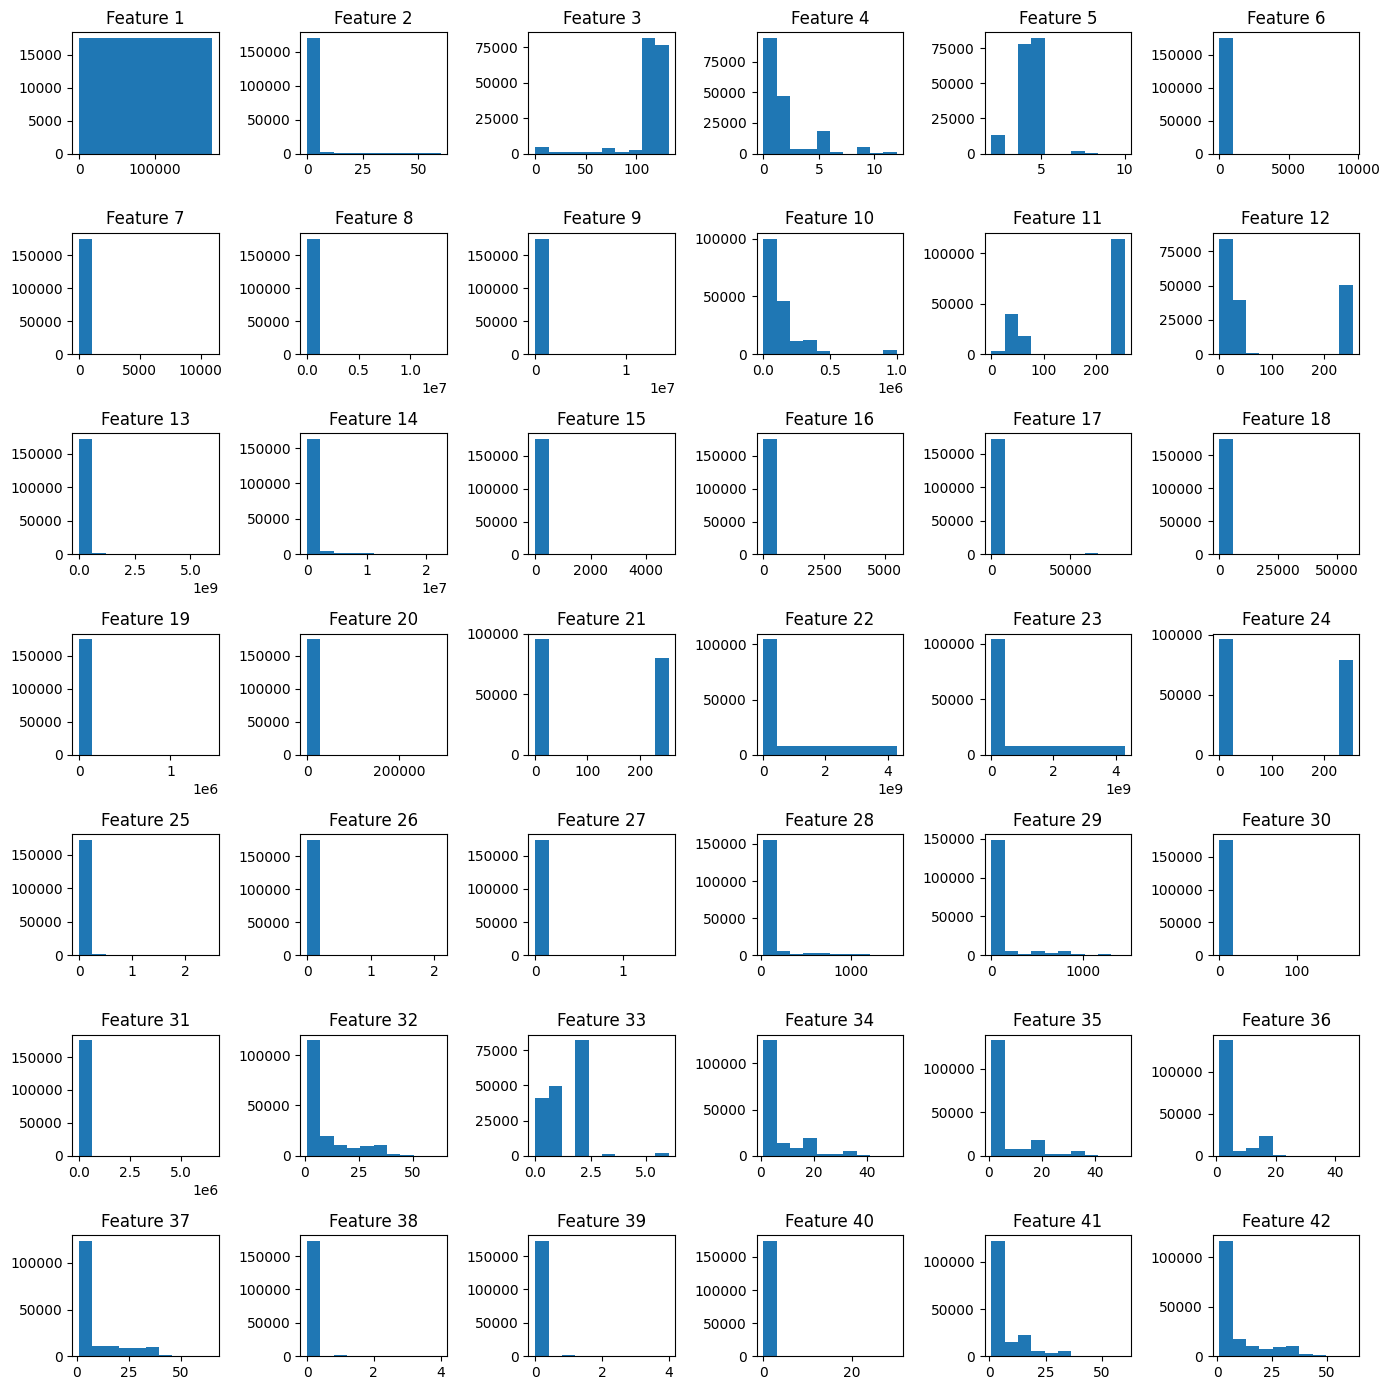

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(7, 6, figsize=(14, 14))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(X_train[1:, i], bins=10)
    ax.set_title(f"Feature {i+1}")

plt.tight_layout()
plt.show()

Pre-processing 
1. There were no missing value in the dataset and I checked it before this section out of this code visually and also with coding so I head to the next step
2. Normalize the Dataset 

P.S. Normalizing the dataset can be helpful here cause the range of the features are different and it can equalize the effect of them in traing process

In [3]:
from sklearn.preprocessing import normalize

X_train = normalize(X_train)
X_test = normalize(X_test)

<h2>Multiple methods for feature selection has applied on the dataset</h2>

<p>1. PCA</p>
<p>2. Recursive Feature Elimination</p>
<p>3. Univariate Selection</p>

<h2>1. PCA</h2>

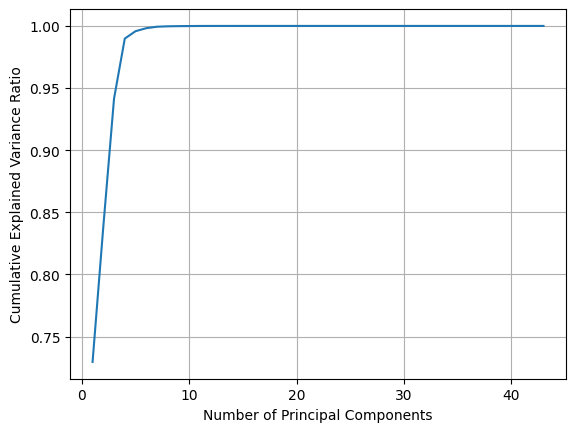

In [4]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cvr) + 1), cvr)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

Chose 9 to be the number of the new components based on the Cumulative Explained Variance Ratio

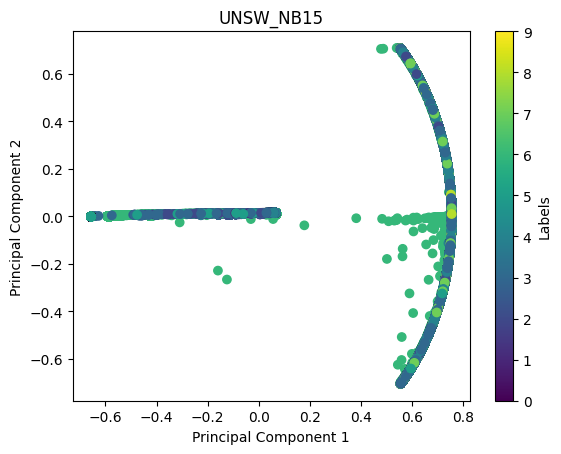

In [5]:
# Perform PCA
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plot the data points in the transformed space
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('UNSW_NB15')
plt.colorbar(label='Labels')
plt.show()

<h2>2. Recursive Feature Elimination</h2>
chose 15 based on the diagram in PCA section

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()

# perform RFE
rfe = RFE(estimator=estimator, n_features_to_select=15)
rfe.fit(X_train, y_train)

selected_indices_rfe = rfe.get_support(indices=True)
print(selected_indices_rfe)

# Prepare Train and Test dataset based on the selected features
X_train_rfe = X_train[:, selected_indices_rfe]
X_test_rfe = X_test[:, selected_indices_rfe]

[ 3  4 15 23 24 25 26 29 31 32 35 37 38 39 42]


<h2>3. Unirative Selection</h2>
chose 15 based on the diagram in PCA section

In [7]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=15)
selector.fit(X_train, y_train)

selected_indices_us = selector.get_support(indices=True)
print(selected_indices_us)

# Prepare Train and Test dataset based on the selected features
X_train_us = X_train[:, selected_indices_us]
X_test_us = X_test[:, selected_indices_us]

[ 0  2  7  8  9 10 12 13 16 17 18 19 21 22 27]


<h2>Training Section</h2>
<h4>Prefered methods are below : </h4>
</br>
<p>1. KNN</p>
<p>2. Random Forest</p>
<p>3. Etreme Learning Model</p>
<p>4. Stacking Model</p>
<p>5. MLP </p>
</br>
<p>P.S. All the feature selections applied to all of the classifiers</p>

<h2>1. KNN</h2>

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors": [7, 9, 11, 13, 15],
}
grid_search_pca = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search_rfe = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search_us = GridSearchCV(knn, param_grid=param_grid, cv=5)

# With PCA
grid_search_pca.fit(X_train_pca, y_train)
best_neighbors_pca = grid_search_pca.best_params_['n_neighbors']
best_estimator_knn_pca = grid_search_pca.best_estimator_
y_predict_knn_pca = best_estimator_knn_pca.predict(X_test_pca)
print("Results with PCA : ")
print("Best number of K : " + str(best_neighbors_pca))
print("Accuracy : " + str(accuracy_score(y_test, y_predict_knn_pca)))
print("Precision : " + str(precision_score(y_test, y_predict_knn_pca, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_knn_pca, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_knn_pca, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_knn_pca)))


# With RFE
grid_search_rfe.fit(X_train_rfe, y_train)
best_neighbors_rfe = grid_search_rfe.best_params_['n_neighbors']
best_estimator_knn_rfe = grid_search_rfe.best_estimator_
y_predict_knn_rfe = best_estimator_knn_rfe.predict(X_test_rfe)
print("Results with RFE : ")
print("Best number of K : " + str(best_neighbors_rfe))
print("Accuracy : " + str(accuracy_score(y_test, y_predict_knn_rfe)))
print("Precision : " + str(precision_score(y_test, y_predict_knn_rfe, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_knn_rfe, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_knn_rfe, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_knn_rfe)))


# With US
grid_search_us.fit(X_train_us, y_train)
best_neighbors_us = grid_search_us.best_params_['n_neighbors']
best_estimator_knn_us = grid_search_us.best_estimator_
y_predict_knn_us = best_estimator_knn_us.predict(X_test_us)
print("Results with US : ")
print("Best number of K : " + str(best_neighbors_us))
print("Accuracy : " + str(accuracy_score(y_test, y_predict_knn_us)))
print("Precision : " + str(precision_score(y_test, y_predict_knn_us, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_knn_us, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_knn_us, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_knn_us)))


Results with PCA : 
Best number of K : 13
Accuracy : 0.4777850653451878
Precision : 0.5817609703892407
Recall : 0.4777850653451878
F1 Score : 0.5084717814720889
Confusion Matrix : [[    4    15   125   380    42     3   104     4     0     0]
 [    4     6   124   392    11     6    35     5     0     0]
 [   12   191   339  1437   522    47  1489    50     2     0]
 [   33   159   479  5355  1463    55  3465   122     1     0]
 [   26    34   295  2755  1148   169  1579    56     0     0]
 [    3   108    14   442  5454  9950  1951   949     0     0]
 [   57     8   226  9304  4571   873 21750   195    16     0]
 [    6    73   100  1192   388    18   937   782     0     0]
 [    0     7    22   133    79    10   105    19     3     0]
 [    0     0     0    19     7     0    15     3     0     0]]


e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results with RFE : 
Best number of K : 11
Accuracy : 0.6553223533984356
Precision : 0.7124004540674701
Recall : 0.6553223533984356
F1 Score : 0.6750032129656204
Confusion Matrix : [[    0    65   187   165    91   132    37     0     0     0]
 [    1     2   178   161    66   132    35     8     0     0]
 [  264   754   554  1499   308   142   432   123    13     0]
 [  257   666   698  6148   947   289  1664   449    14     0]
 [   35    98   404   584  2795   280  1739   123     4     0]
 [    1     9   182   530   205 17711   193    34     6     0]
 [  204     9   198  3050  7605    67 24862   963    42     0]
 [   34    94    60   630   511     3   321  1841     2     0]
 [    0     0    14    36   122     2    39   124    41     0]
 [    0     0     0    31     4     0     4     4     1     0]]


e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results with US : 
Best number of K : 15
Accuracy : 0.5957829276587475
Precision : 0.6770696963926571
Recall : 0.5957829276587475
F1 Score : 0.6199009660946486
Confusion Matrix : [[    3   113   127   393    18     1    22     0     0     0]
 [    4    15   116   414     8     4    22     0     0     0]
 [    8  1435   356  1495   243    32   499    18     3     0]
 [   28  1252   482  5430  1208    39  2631    57     5     0]
 [   23   192   268  2763  1263     5  1495    39    14     0]
 [    1     4    23   330   149 17975   382     6     1     0]
 [   42     3   162  9194  4478    18 22918   142    43     0]
 [    4   189    45  1080   280    11   813  1071     3     0]
 [    0     6    18   144    85     8    90     6    21     0]
 [    0     0     0    19     5     0    18     2     0     0]]


e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2>2. Random Forest</h2>

In [9]:
from sklearn.ensemble import RandomForestClassifier

# With PCA
random_forest_pca = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_pca.fit(X_train_pca, y_train)
y_predict_rf_pca = random_forest_pca.predict(X_test_pca)
print("Results with PCA : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_rf_pca)))
print("Precision : " + str(precision_score(y_test, y_predict_rf_pca, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_rf_pca, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_rf_pca, average='weighted')))
print("confusion Matrix : " + str(confusion_matrix(y_test, y_predict_rf_pca)))

# With RFE
random_forest_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_rfe.fit(X_train_rfe, y_train)
y_predict_rf_rfe = random_forest_rfe.predict(X_test_rfe)
print("Results with RFE : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_rf_rfe)))
print("Precision : " + str(precision_score(y_test, y_predict_rf_rfe, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_rf_rfe, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_rf_rfe, average='weighted')))
print("confusion Matrix : " + str(confusion_matrix(y_test, y_predict_rf_rfe)))

# With US
random_forest_us = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_us.fit(X_train_us, y_train)
y_predict_rf_us = random_forest_us.predict(X_test_us)
print("Results with US : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_rf_us)))
print("Precision : " + str(precision_score(y_test, y_predict_rf_us, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_rf_us, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_rf_us, average='weighted')))
print("confusion Matrix : " + str(confusion_matrix(y_test, y_predict_rf_us)))

Results with PCA : 
Accuracy : 0.4849390273526697
Precision : 0.5864070704448366
Recall : 0.4849390273526697
F1 Score : 0.5151134937089797
confusion Matrix : [[    4    11    79   390    63     0   122     8     0     0]
 [    6    11    71   389    44     2    52     8     0     0]
 [    9    94   163  1185   737    16  1817    57     9     2]
 [   32    92   335  4330  1399    10  4646   261    25     2]
 [   27    26   206  1935  1661    13  1910   245    37     2]
 [    1     3  1254   247  4003  9872  2057   177  1257     0]
 [   72   108   429  5815  6298    42 22786  1259   158    33]
 [   10    45    40   633   366     1  1307  1080    13     1]
 [    0     2     9    73    89     6   146    34    19     0]
 [    0     0     0    12     6     0    24     2     0     0]]
Results with RFE : 
Accuracy : 0.45119759024437645
Precision : 0.4983893488926834
Recall : 0.45119759024437645
F1 Score : 0.28449996089081786
confusion Matrix : [[    0     2     0     8     2     0   665     0 

e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results with US : 
Accuracy : 0.4391609580721955
Precision : 0.5841249474058042
Recall : 0.4391609580721955
F1 Score : 0.4532524573086317
confusion Matrix : [[    1     1     8   383    12     0   165     0   107     0]
 [    0     4     8   376    20     0    66     0   109     0]
 [    4     2    36   848   115     0  2950    21   113     0]
 [    2     2    24  4240   258     0  6377     7   222     0]
 [    4     2    13  1755  1442     0  2589     6   251     0]
 [    0     0  1994   365    97  5261  2643     6  8505     0]
 [    3     1    10  6561  5940     0 24380    82    23     0]
 [    0     0     2   414   192     0  2122   764     2     0]
 [    0     0     0    55    68     1   213    12    29     0]
 [    0     0     0    12     3     0    29     0     0     0]]


e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2>3. Etreme Learning Model</h2>
</br>
<p>P.S. Impelementation is based on the Kaggle website with a little manipulation</p>

In [10]:
# With PCA
INPUT_LENGHT = X_train_pca.shape[1] # 9
HIDDEN_UNITS = 1000

Win = np.random.normal(size=[INPUT_LENGHT, HIDDEN_UNITS])

def input_to_hidden(x):
    a = np.dot(x, Win)
    a = np.maximum(a, 0, a) # ReLU
    return a

X_pca = input_to_hidden(X_train_pca)
Xt_pca = np.transpose(X_pca)
Wout_pca = np.dot(np.linalg.inv(np.dot(Xt_pca, X_pca)), np.dot(Xt_pca, y_train))

def predict(x):
    x = input_to_hidden(x)
    y = np.dot(x, Wout_pca)
    return y

y = predict(X_test_pca)
correct = 0
total = y.shape[0]
for i in range(total):
    predicted = np.argmax(y[i])
    test = np.argmax(y_test[i])
    correct = correct + (1 if predicted == test else 0)
print("PCA Results : ")
print('Accuracy : {:f}'.format(correct/total))

PCA Results : 
Accuracy : 1.000000


In [11]:
# With RFE
INPUT_LENGHT = X_train_rfe.shape[1] # 15
HIDDEN_UNITS = 1000

Win = np.random.normal(size=[INPUT_LENGHT, HIDDEN_UNITS])

def input_to_hidden(x):
    a = np.dot(x, Win)
    a = np.maximum(a, 0, a) # ReLU
    return a

X_rfe = input_to_hidden(X_train_rfe)
Xt_rfe = np.transpose(X_rfe)
Wout_rfe = np.dot(np.linalg.pinv(np.dot(Xt_rfe, X_rfe)), np.dot(Xt_rfe, y_train))

def predict(x):
    x = input_to_hidden(x)
    y = np.dot(x, Wout_rfe)
    return y

y = predict(X_test_rfe)
correct = 0
total = y.shape[0]
for i in range(total):
    predicted = np.argmax(y[i])
    test = np.argmax(y_test[i])
    correct = correct + (1 if predicted == test else 0)

print("RFE Results : ")
print('Accuracy: {:f}'.format(correct/total))

RFE Results : 
Accuracy: 1.000000


In [12]:
# With US
INPUT_LENGHT = X_train_us.shape[1] # 15
HIDDEN_UNITS = 1000

Win = np.random.normal(size=[INPUT_LENGHT, HIDDEN_UNITS])

def input_to_hidden(x):
    a = np.dot(x, Win)
    a = np.maximum(a, 0, a) # ReLU
    return a

X_us = input_to_hidden(X_train_us)
Xt_us = np.transpose(X_us)
Wout_us = np.dot(np.linalg.pinv(np.dot(Xt_us, X_us)), np.dot(Xt_us, y_train))

def predict(x):
    x = input_to_hidden(x)
    y = np.dot(x, Wout_us)
    return y

y = predict(X_test_us)
correct = 0
total = y.shape[0]
for i in range(total):
    predicted = np.argmax(y[i])
    test = np.argmax(y_test[i])
    correct = correct + (1 if predicted == test else 0)

print("US Results : ")
print('Accuracy: {:f}'.format(correct/total))

US Results : 
Accuracy: 1.000000


<h2>4. Stacking Model</h2>

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# With PCA
base_classifiers_pca = [
    ('rf', random_forest_pca),
    ('knn', KNeighborsClassifier(n_neighbors=13)),
    ('SVC', SVC()),
    ]

meta_estimator = KNeighborsClassifier(n_neighbors=13)
stacking_classifier_pca = StackingClassifier(estimators=base_classifiers_pca, final_estimator=meta_estimator)
stacking_classifier_pca.fit(X_train_pca, y_train)
y_pred_st_pca = stacking_classifier_pca.predict(X_test_pca)

print("Results with PCA : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_st_pca)))
print("Precision : " + str(precision_score(y_test, y_predict_st_pca, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_st_pca, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_st_pca, average='weighted')))
print("confusion Matrix : " + str(confusion_matrix(y_test, y_predict_st_pca)))

<h2>5. MLP Classifier</h2>

PCA with one hidden layer

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

mlp = MLPClassifier(random_state=42, hidden_layer_sizes=(1000), 
                    activation='relu', learning_rate_init=0.001,
                    batch_size=64, max_iter=10)

mlp.fit(X_train_pca, y_train)
y_predict_mlp_pca = mlp.predict(X_test_pca)
print("Results of PCA : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_mlp_pca)))
print("Precision : " + str(precision_score(y_test, y_predict_mlp_pca, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_mlp_pca, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_mlp_pca, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_mlp_pca)))


e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Results of PCA : 
Accuracy : 0.5940339114803479
Precision : 0.4982248275983675
Recall : 0.5940339114803479
F1 Score : 0.524817878299853
Confusion Matrix : [[    0     0     0    27     0   603    47     0     0     0]
 [    0     0     1    49     0   491    42     0     0     0]
 [    0     0    51   451    24  2703   860     0     0     0]
 [    0     0   102  2459    30  2977  5564     0     0     0]
 [    0     0     0  1114     1  2205  2742     0     0     0]
 [    0     0     4   184     1 18289   393     0     0     0]
 [    0     0     2  4247     0  4643 28108     0     0     0]
 [    0     0    15   559     5  1580  1337     0     0     0]
 [    0     0     0    61     0   185   132     0     0     0]
 [    0     0     0     8     0     6    30     0     0     0]]


e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RFE with one hidden layer

In [14]:
mlp_rfe = MLPClassifier(random_state=42, hidden_layer_sizes=(1000), 
                    activation='relu', learning_rate_init=0.001,
                    batch_size=64, max_iter=10)

mlp_rfe.fit(X_train_rfe, y_train)
y_predict_mlp_rfe = mlp_rfe.predict(X_test_rfe)
print("Results of RFE : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_mlp_rfe)))
print("Precision : " + str(precision_score(y_test, y_predict_mlp_rfe, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_mlp_rfe, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_mlp_rfe, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_mlp_rfe)))

e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Results of RFE : 
Accuracy : 0.44939999028324346
Precision : 0.2019603512665793
Recall : 0.44939999028324346
F1 Score : 0.2786813200227937
Confusion Matrix : [[    0     0     0     0     0     0   677     0     0     0]
 [    0     0     0     0     0     0   583     0     0     0]
 [    0     0     0     0     0     0  4089     0     0     0]
 [    0     0     0     0     0     0 11132     0     0     0]
 [    0     0     0     0     0     0  6062     0     0     0]
 [    0     0     0     0     0     0 18871     0     0     0]
 [    0     0     0     0     0     0 37000     0     0     0]
 [    0     0     0     0     0     0  3496     0     0     0]
 [    0     0     0     0     0     0   378     0     0     0]
 [    0     0     0     0     0     0    44     0     0     0]]


e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


US with one hidden layer

In [15]:
mlp_us = MLPClassifier(random_state=42, hidden_layer_sizes=(1000), 
                    activation='relu', learning_rate_init=0.001,
                    batch_size=64, max_iter=10)

mlp_rfe.fit(X_train_us, y_train)
y_predict_mlp_us = mlp_rfe.predict(X_test_us)
print("Results of RFE : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_mlp_us)))
print("Precision : " + str(precision_score(y_test, y_predict_mlp_us, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_mlp_us, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_mlp_us, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_mlp_us)))

e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Results of RFE : 
Accuracy : 0.5446484963319244
Precision : 0.6615332616359333
Recall : 0.5446484963319244
F1 Score : 0.5264092565263913
Confusion Matrix : [[    0     0     0   664     0     2    11     0     0     0]
 [    0     0     0   561     0     4    18     0     0     0]
 [    0     0     7  3639    27   138   278     0     0     0]
 [    0     0     2  9603    33   138  1356     0     0     0]
 [    0     0     0  5139    21   386   516     0     0     0]
 [    0     0     0   571     0 18162   138     0     0     0]
 [    0     0     0 17061    85  2805 17049     0     0     0]
 [    0     0     0  3202     4    48   242     0     0     0]
 [    0     0     0   338     0    21    19     0     0     0]
 [    0     0     0    34     0     2     8     0     0     0]]


e:\tuts\DataMining\Homeworks\Final_Project\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PCA with 3 hidden layers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

mlp = MLPClassifier(random_state=42, hidden_layer_sizes=(128, 128, 128), 
                    activation='relu', learning_rate_init=0.001,
                    batch_size=64, max_iter=10)

mlp.fit(X_train_pca, y_train)
y_predict_mlp_pca = mlp.predict(X_test_pca)
print("Results of PCA : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_mlp_pca)))
print("Precision : " + str(precision_score(y_test, y_predict_mlp_pca, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_mlp_pca, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_mlp_pca, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_mlp_pca)))


RFE with 3 hidden layers

In [ ]:
mlp_rfe = MLPClassifier(random_state=42, hidden_layer_sizes=(128, 64, 128), 
                    activation='relu', learning_rate_init=0.001,
                    batch_size=64, max_iter=10)

mlp_rfe.fit(X_train_rfe, y_train)
y_predict_mlp_rfe = mlp_rfe.predict(X_test_rfe)
print("Results of RFE : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_mlp_rfe)))
print("Precision : " + str(precision_score(y_test, y_predict_mlp_rfe, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_mlp_rfe, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_mlp_rfe, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_mlp_rfe)))

US with 3 hidden layers

In [ ]:
mlp_us = MLPClassifier(random_state=42, hidden_layer_sizes=(128, 64, 128), 
                    activation='relu', learning_rate_init=0.001,
                    batch_size=64, max_iter=10)

mlp_us.fit(X_train_us, y_train)
y_predict_mlp_us = mlp_us.predict(X_test_us)
print("Results of US : ")
print("Accuracy : " + str(accuracy_score(y_test, y_predict_mlp_us)))
print("Precision : " + str(precision_score(y_test, y_predict_mlp_us, average='weighted')))
print("Recall : " + str(recall_score(y_test, y_predict_mlp_us, average='weighted')))
print("F1 Score : " + str(f1_score(y_test, y_predict_mlp_us, average='weighted')))
print("Confusion Matrix : " + str(confusion_matrix(y_test, y_predict_mlp_us)))